# Load Dataset

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="aFrVbcrqu4udJMVQrCGz")
project = rf.workspace("segment1-yellowbanana").project("waste-identification-a3v9y")
version = project.version(1)
dataset = version.download("folder")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Waste-identification-1 in folder:: 100%|██████████| 13067/13067 [00:02<00:00, 5700.50it/s]


In [ ]:
PATH = '/content/Waste-identification-1/'


In [ ]:
def load_dataset(PATH):
    images = []
    labels = []
    class_names = sorted(os.listdir(PATH))
    for idx, class_name in enumerate(class_names):
        class_folder = os.path.join(PATH, class_name)
        if os.path.isdir(class_folder):
            for file_name in os.listdir(class_folder):
                file_path = os.path.join(class_folder, file_name)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    if idx < len(class_names):
                        labels.append(idx)
                    else:
                        print(f"Warning: Found a label index {idx} which is out of range for class_names")
    return np.array(images), np.array(labels), class_names

In [ ]:
train_images, train_labels, train_class_names = load_dataset(PATH + 'train')
val_images, val_labels, val_class_names = load_dataset(PATH + 'valid')
test_images, test_labels, test_class_names = load_dataset(PATH + 'test')

In [ ]:
print(f"Train: {len(train_images)}, Validation: {len(val_images)}, Test: {len(test_images)}")

Train: 12039, Validation: 503, Test: 502


# Extract Features using SIFT

In [ ]:
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    descriptors_list = []
    for img in images:
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    return descriptors_list

train_descriptors = extract_sift_features(train_images)
val_descriptors = extract_sift_features(val_images)
test_descriptors = extract_sift_features(test_images)


# Build Bag of Features

In [ ]:
def build_bof(descriptors_list, n_clusters=250):
    all_descriptors = np.vstack(descriptors_list)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans

n_clusters = 250
kmeans = build_bof(train_descriptors, n_clusters=n_clusters)

# Histogram

In [ ]:
def create_histogram(descriptors, kmeans, n_clusters):
    histogram = np.zeros(n_clusters)
    if descriptors is not None:
        cluster_assignments = kmeans.predict(descriptors)
        for assignment in cluster_assignments:
            histogram[assignment] += 1
    return histogram



In [ ]:
def create_bof_histograms(descriptors_list, kmeans, n_clusters):
    histograms = []
    for descriptors in descriptors_list:
        hist = create_histogram(descriptors, kmeans, n_clusters)
        histograms.append(hist)
    return np.array(histograms)

In [ ]:
train_histograms = create_bof_histograms(train_descriptors, kmeans, n_clusters)
val_histograms = create_bof_histograms(val_descriptors, kmeans, n_clusters)
test_histograms = create_bof_histograms(test_descriptors, kmeans, n_clusters)

# Check Before Training

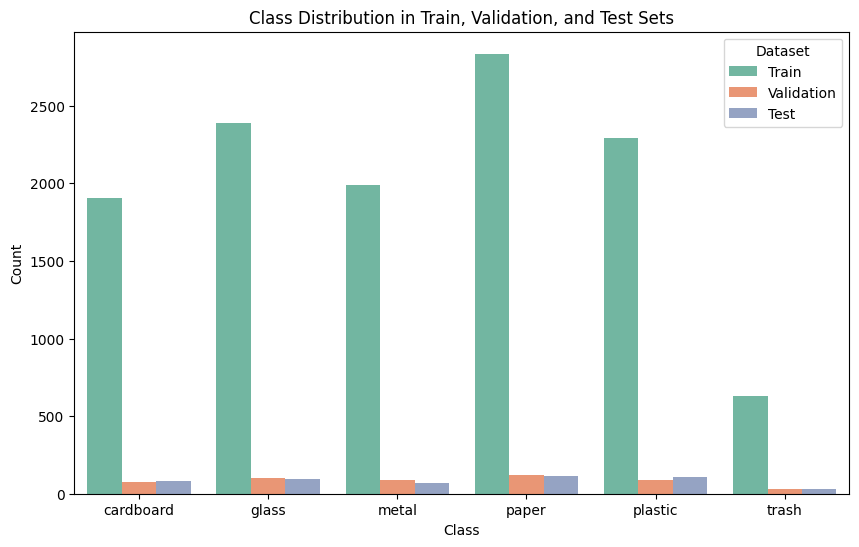

In [ ]:
def count_classes(labels, class_names):
    class_counts = pd.DataFrame(
        {
            "Class": [class_names[label] for label in labels],
            "Count": 1
        }
    ).groupby("Class").count().reset_index()
    return class_counts

train_class_counts = count_classes(train_labels, train_class_names)
val_class_counts = count_classes(val_labels, val_class_names)
test_class_counts = count_classes(test_labels, test_class_names)

train_class_counts["Dataset"] = "Train"
val_class_counts["Dataset"] = "Validation"
test_class_counts["Dataset"] = "Test"

class_counts = pd.concat([train_class_counts, val_class_counts, test_class_counts])
# class_counts = pd.concat([train_class_counts,  test_class_counts])

plt.figure(figsize=(10, 6))
sns.barplot(x="Class", y="Count", hue="Dataset", data=class_counts, palette="Set2")
plt.title("Class Distribution in Train, Validation, and Test Sets")
plt.show()


In [ ]:
def count_and_print_distributions(labels, set_name, class_names):
    class_counts = pd.DataFrame(
        {
            "Class": [class_names[label] for label in labels],
            "Count": 1
        }
    ).groupby("Class").count().reset_index()
    class_counts["Dataset"] = set_name
    print(f"\n{set_name} set class distribution:")
    print(class_counts)
    return class_counts

train_class_counts = count_and_print_distributions(train_labels, "Train", train_class_names)
val_class_counts = count_and_print_distributions(val_labels, "Validation", val_class_names)
test_class_counts = count_and_print_distributions(test_labels, "Test", test_class_names)



Train set class distribution:
       Class  Count Dataset
0  cardboard   1905   Train
1      glass   2391   Train
2      metal   1986   Train
3      paper   2835   Train
4    plastic   2292   Train
5      trash    630   Train

Validation set class distribution:
       Class  Count     Dataset
0  cardboard     78  Validation
1      glass    100  Validation
2      metal     86  Validation
3      paper    121  Validation
4    plastic     86  Validation
5      trash     32  Validation

Test set class distribution:
       Class  Count Dataset
0  cardboard     85    Test
1      glass     95    Test
2      metal     69    Test
3      paper    113    Test
4    plastic    110    Test
5      trash     30    Test


In [ ]:
print(f"Number of train histograms: {len(train_histograms)} | train labels: {len(train_labels)}")
print(f"Number of test histograms: {len(test_histograms)} | test labels: {len(test_labels)}")
print(f"Number of valid histograms: {len(val_histograms)} | valid labels: {len(val_labels)}")

Number of train histograms: 12019 | train labels: 12039
Number of test histograms: 497 | test labels: 502
Number of valid histograms: 502 | valid labels: 503


In [ ]:
print(f"Number of train histograms: {len(train_histograms)} | train labels: {len(train_labels)}")
print(f"Number of valid histograms: {len(val_histograms)} | valid labels: {len(val_labels)}")
print(f"Number of test histograms: {len(test_histograms)} | test labels: {len(test_labels)}")

In [ ]:
# If train histogram and labels not equal
if len(train_histograms) > len(train_labels):
    train_histograms = train_histograms[:len(train_labels)]
elif len(train_labels) > len(train_histograms):
    train_labels = train_labels[:len(train_histograms)]

In [ ]:
# If val histogram and labels not equal
if len(val_histograms) > len(val_labels):
    val_histograms = val_histograms[:len(val_labels)]
elif len(val_labels) > len(val_histograms):
    val_labels = val_labels[:len(val_histograms)]

In [ ]:
# If test histogram and labels not equal
if len(test_histograms) > len(test_labels):
    test_histograms = test_histograms[:len(test_labels)]
elif len(test_labels) > len(test_histograms):
    test_labels = test_labels[:len(test_histograms)]

#Training

In [ ]:
scaler = StandardScaler()
train_histograms = scaler.fit_transform(train_histograms)
val_histograms = scaler.transform(val_histograms)
test_histograms = scaler.transform(test_histograms)


In [ ]:
svm = SVC(kernel='rbf', C=10.0, gamma=0.001)
svm.fit(train_histograms, train_labels)

SVC(C=10.0, gamma=0.001)

# Evaluation

In [ ]:
def evaluate_model(model, histograms, labels):
    predictions = model.predict(histograms)
    accuracy = accuracy_score(labels, predictions)
    conf_matrix = confusion_matrix(labels, predictions)
    class_report = classification_report(labels, predictions, zero_division=1)  # Add zero_division=1
    return accuracy, conf_matrix, class_report

train_accuracy, train_conf_matrix, train_report = evaluate_model(svm, train_histograms, train_labels)
test_accuracy, test_conf_matrix, test_report = evaluate_model(svm, test_histograms, test_labels)
val_accuracy, val_conf_matrix, val_report = evaluate_model(svm, val_histograms, val_labels)


In [ ]:
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("Classification Report (Test):")
print(test_report)

Training Accuracy: 0.7660371079124719
Validation Accuracy: 0.6354581673306773
Test Accuracy: 0.6197183098591549
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.73      0.64      0.68        85
           1       0.52      0.63      0.57        95
           2       0.63      0.67      0.65        69
           3       0.76      0.69      0.72       113
           4       0.55      0.57      0.56       110
           5       0.41      0.28      0.33        25

    accuracy                           0.62       497
   macro avg       0.60      0.58      0.59       497
weighted avg       0.63      0.62      0.62       497



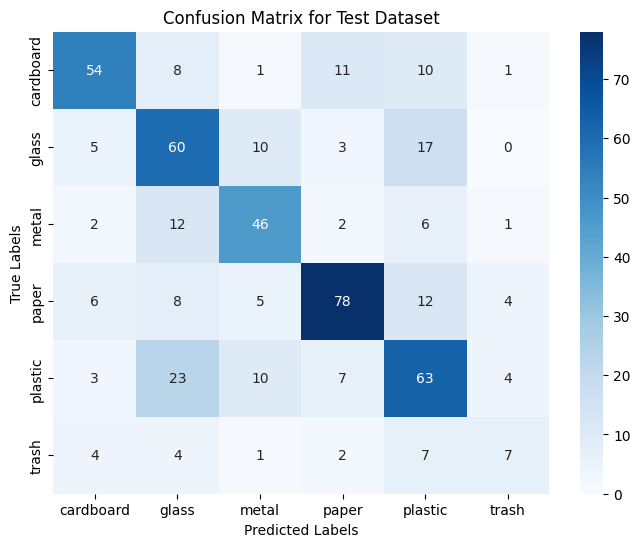

In [ ]:
def plot_confusion_matrix(conf_matrix, class_names, dataset_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix for {dataset_name} Dataset")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

plot_confusion_matrix(test_conf_matrix, class_names, "Test")

# Save Model

In [ ]:
from google.colab import files

In [1]:
model_filename = '/content/ModelSVM.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(svm, file)

print("Model is saved")
files.download(model_filename)

Model is saved


In [ ]:
scaler_filename = '/content/Scaler-SIFT-SVM.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler is saved")
files.download(scaler_filename)

Scaler is saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
kmeans_filename = '/content/KMeans-SIFT-SVM.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(kmeans, file)

print("KMeans is saved")
files.download(kmeans_filename)

KMeans is saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>